## Extract data from SOLEIL SWING beamline files

## Overview

The `SwingData` and `SwingBatch` classes are designed to extract, integrate, and plot synchrotron data from HDF5 files. They leverage libraries such as **pyFAI** for azimuthal integration and **fabio** for reading image data. The code also supports saving integration results to text files and generating summary plots and videos.

---

## Classes

### 1. SwingData

**Purpose:**

- Extract experimental parameters and images from an HDF5 file.
- Perform azimuthal integration on the Eiger detector data.
- Save integration results and generate plots.

**Key Methods:**

#### `extract_from_h5()`
Extracts parameters (sample name, detector images, beam center, pixel size, wavelength, etc.) and stores them in a dictionary (`self.params`).

#### `integrate(sectors=[(0, 180)], mean=False)`
Integrates either the mean image (`eiger_mean`) or all individual frames (`eiger`) over specified sectors.

**Parameters:**
- `sectors`: List of tuples `(angle, delta_angle)` specifying integration sectors in degrees.
- `mean`: If `True`, uses the mean image; if `False`, integrates each frame.

**Returns:**
- A dictionary of integration results with keys `(angle, delta_angle)` and values containing arrays for `q`, `i_raw`, and `i_normalize`.
- Computes a chi-map (`self.chi_array`) using the AzimuthalIntegrator.

#### `save_integration(integration_results, normalized=False)`
Saves the integration results to text files. Filenames include the sample’s reduced filename, sector information, and frame number if applicable.

**Parameters:**
- `integration_results`: The dictionary returned by `integrate()`.
- `normalized`: If `True`, saves normalized intensity (`i_normalize`); otherwise, saves raw intensity (`i_raw`).

#### `plot_data(integration_results, normalized=True, basler_coords=(0, 0), output_filename=None)`
Creates plots that combine:
- The **Basler image** (with a marker at the measurement point).
- The **Eiger mean image** with an overlay of the chi-map for the selected sector.
- A **log–log plot** of the integrated intensity versus *q*.

#### `_create_plot(...)` *(helper function)*
Used internally to generate and save individual plots based on the integration data. It displays three panels (Basler image, Eiger mean image with chi-map, and the integration plot) and saves the figure.

---

### 2. SwingBatch

**Purpose:**

- Process a batch of HDF5 files using the `SwingData` class.
- Provide progress feedback.
- Generate text file outputs for integration results.
- Create a video from the generated plot images.

**Key Methods:**

#### `get_h5_files()`
Returns a list of HDF5 files in the specified data directory.

#### `process()`
Iterates over all HDF5 files in the directory and processes each file (extraction, integration, saving results, plotting). Displays progress in the terminal or in a Jupyter Notebook.

#### `_process_single_file(file_path)`
Processes one file by instantiating `SwingData`, performing integration, saving the results, and generating plots.

#### `_log_results()`
Writes a log file summarizing the processing (which files succeeded and which failed, with error details).

#### `get_report()`
Returns a text report summarizing the processing results.

#### `create_video_from_images(output_filename="output_video.mp4", fps=10)`
Combines the generated plot images (stored in the "plots" folder) into an MP4 video.

---

### 3. **TextFileProcessor**

**Purpose:**

- This class is designed to load, store, and process data from text files in the Foxtrot format.
- It supports loading multiple files with different `skiprows` values to find the correct data, retrieving stored data, and subtracting data from two files.

---

**Key Methods:**

#### `__init__(self)`
Initializes the `TextFileProcessor` object with an empty dictionary to store the file data.

**Parameters:**
- No parameters for initialization.

#### `load_txt(self, path)`
Loads q and i data from a Foxtrot-format text file, attempting different `skiprows` values.

**Parameters:**
- `path`: The file path of the text file to load.

**Returns:**
- `(q, i)`: The q and i data arrays if the file is successfully loaded, otherwise `None, None`.

**Details:**
- The method tries different values of `skiprows` (from 0 to 99) to load the file. If successful, it stores the data in a dictionary (`self.files`), with the file path as the key and the `(q, i)` tuple as the value.

#### `get_data(self, path)`
Retrieves the stored q and i data for a given file path.

**Parameters:**
- `path`: The file path of the text file.

**Returns:**
- `(q, i)`: The stored q and i data if the file is found, otherwise `(None, None)`.

#### `subtract_files(self, file1, file2)`
Subtracts data from two files and saves the result in a new file inside a `sub` subdirectory.

**Parameters:**
- `file1`: The first file to subtract from.
- `file2`: The second file to subtract.

**Returns:**
- None. The result is saved as a new text file in the `sub` folder.

**Details:**
- The method retrieves the data from `file1` and `file2`. If the `q` values are different, it performs interpolation to match them.
- The subtraction of `i` values is done element-wise (`i1 - i2_interpolated`).
- The result is saved in a new text file, with the name formatted as `file1_name-file2_name_subtracted.txt`.

---




### Usage Example
#### 1- Single file process

- import SwingData class (make sure swing_tools file is in same directory than your current notebook)
- import numpy and matplotlib

In [1]:
from swing_tools import SwingData
import matplotlib.pyplot as plt
import numpy as np


- Define measurment (*.h5) and mask (*.edf)  file paths 

In [2]:
file_path = 'path/*.h5'
maskfile = 'path/*.edf'

- Create an instance of the class `SwingData`

In [3]:
data = SwingData(file_path,maskfile)

- Acces do data attributes

Sample name:R_C_1_P_1
Position dictionnary:{'X_start': array([29.4998]), 'X_end': array([29.4998]), 'Z_start': array([90.6993]), 'Z_end': array([90.6993])}


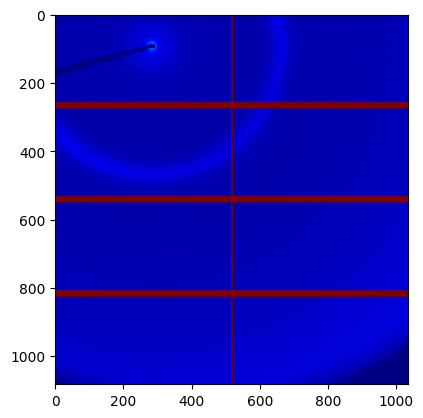

In [4]:
print(f"Sample name:{data.params["Sample_Name"]}")
print(f"Position dictionnary:{data.params["position"]}")
eiger = data.params["eiger_mean"]

fig,ax = plt.subplots()
ax.imshow(np.log1p(eiger), cmap='jet');

- Integrations: ``````integrate`````` method returns a dictionnary. The keys are the angles of integration , by default ``````[(0,180)]``````, from 0°+/-180° i.e. iso integration.  
**Warning**:  PyFAI count angles clockwise

![angles](images/angles1.png)

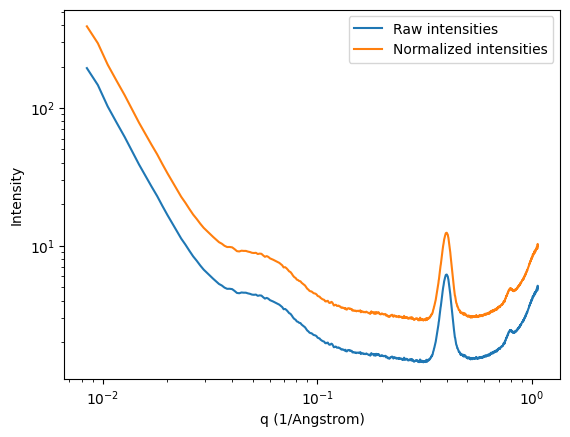

In [5]:
results = data.integrate()
angle_sectors = list(results.keys())  # Get the list of keys (angle, delta_angle)
q_values = results[angle_sectors[0]]["q"]  # Access q values for the first sector
i_raw_values = results[angle_sectors[0]]["i_raw"]  # Access i(q) for the first sector
i_normalized_values = results[angle_sectors[0]]["i_normalize"] # Access i(q) normalized for the first sector

fig,ax = plt.subplots()
ax.loglog(q_values,i_raw_values,label = 'Raw intensities')
ax.loglog(q_values,i_normalized_values,label = 'Normalized intensities')
ax.set_xlabel('q (1/Angstrom)')
ax.set_ylabel('Intensity')
ax.legend()

- It is possible to integrate on a list of different sectors (here 0°+/5°). ``````mean= False``````  will do an integration for each of the frames (here 6)

[(0, 5), (90, 5)]
(1000,)


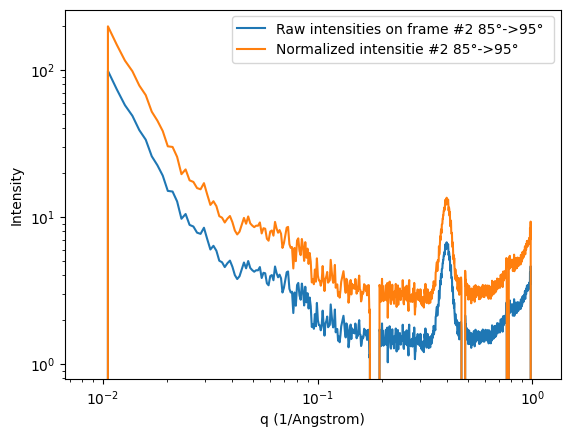

In [6]:
data_with_sectors = SwingData(file_path,maskfile,sectors=[(0,5),(90,5)])
results = data_with_sectors.integrate( mean=False)
angle_sectors = list(results.keys())
q_values_sector0= results[angle_sectors[0]]["q"]  # Access q values for the first sector
i_raw_values_sector0  = results[angle_sectors[0]]["i_raw"]  # Access i(q) for the first sector
i_normalized_values_sector0  = results[angle_sectors[0]]["i_normalize"] # Access i(q) normalized for the first sector

q_values_sector1  = results[angle_sectors[1]]["q"]  # Access q values for the second sector
i_raw_values_sector1 = results[angle_sectors[1]]["i_raw"]  # Access i(q) for the second sector
i_normalized_values_sector1 = results[angle_sectors[1]]["i_normalize"] # Access i(q) normalized for the second sector

print(angle_sectors)
print(q_values.shape)

fig,ax = plt.subplots()
ax.loglog(q_values_sector1[2, :],i_raw_values_sector1[2, :],label = 'Raw intensities on frame #2 85°->95° ')
ax.loglog(q_values_sector1[2, :],i_normalized_values_sector1[2, :],label = 'Normalized intensitie #2 85°->95°')
ax.set_xlabel('q (1/Angstrom)')
ax.set_ylabel('Intensity')
ax.legend();

#### 2- Batch Process

- import ``````SwingBatch``````

In [7]:
from swing_tools import SwingBatch

- Select directory containing *.h5 files to be processed and maskfile

In [8]:
# Directory containing the HDF5 files
data_directory = 'folders/'
# Path to the mask file
mask_file = 'path/*.edf'

- Chose parameters

In [9]:
# Choose whether to integrate the mean image or all frames (True = mean image)
integrate_mean = True
# Choose whether to use normalized integrated intensity (True = normalized)
normalize = True
# Sectors to integrate, defined as a list of tuples (angle, delta_angle)
sectors =[(0,5),(90,5)]
#sectors =None
# Basler image coordinates to mark the measurement point
basler_coordinates = (508, 534)

- Create an instance of SwingBatch with the provided parameters

In [10]:

batch_processor = SwingBatch(data_directory, mask_file, integrate_mean, normalize, basler_coordinates, sectors=sectors, log_file="processing_log.txt")


------------ Process Start ------------


- Process all files

In [11]:
batch_processor.process()

'Processing... 2/2 files (100%)'

Log file created: C:/Users/cayez/Documents/DONNEES_SIMON/LPCNO/Synchrotron/programme_swing_data/kin6/processing_log.txt


- Print the processing report

In [12]:
print(batch_processor.get_report())

Files converted: 2
Failures: 0



- Create a video from the generated plots

In [13]:
batch_processor.create_video_from_images("ma_video.mp4", fps=1)

Video saved in: C:/Users/cayez/Documents/DONNEES_SIMON/LPCNO/Synchrotron/programme_swing_data/kin6/plots\ma_video.mp4
------------ Process Finish ------------


This process will create 2 folders:  
- integration with text files 
- plots  with image of plots and video
and 1 log file 
in the data folder

PLots images will look like:  
  
  
![plot](images/01089_2024-10-11_04-33-50.h5_integ_norm_sector_0_5.png)

#### 3- Text Files Handling

- import ````TextFileProcessor```` class

In [14]:
from swing_tools import TextFileProcessor


- Define files to substract

In [15]:
my_code_True_sample = 'path/*1.txt'
my_code_True_ref = 'path/*2.txt'

- Create an istance of TextFileProcessor

In [16]:
processor = TextFileProcessor()

- load files

In [17]:
processor.load_txt(my_code_True_sample)
processor.load_txt(my_code_True_ref)


q_sample, i_sample = processor.get_data(my_code_True_sample)
q_ref, i_ref = processor.get_data(my_code_True_ref)

Successfully loaded C:/Users/cayez/Documents/DONNEES_SIMON/LPCNO/Synchrotron/programme_swing_data/kin6/integration/01089_2024-10-11_04-33-50.h5_integ_norm_sector_0_180.txt with skiprows=0
Successfully loaded C:/Users/cayez/Documents/DONNEES_SIMON/LPCNO/Synchrotron/programme_swing_data/kin6/integration/00908_2024-10-11_03-36-51.h5_integ_norm_sector_0_180.txt with skiprows=0


- Plot data

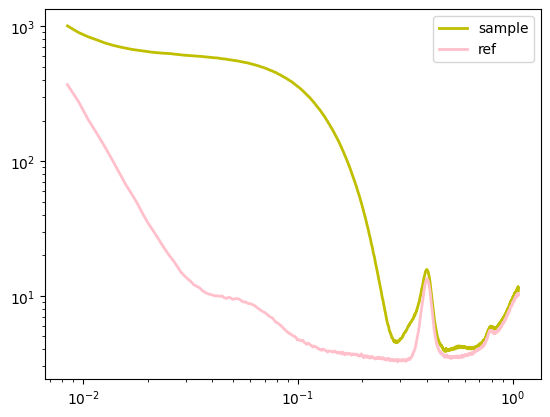

In [18]:
fig,ax = plt.subplots()
ax.loglog(q_sample, i_sample,label = 'sample',linewidth=2,color ='y')
ax.loglog(q_ref, i_ref,label = 'ref',linewidth=2,color = 'pink')
ax.legend();

- substact reference file to sample file

In [19]:
processor.subtract_files(my_code_True_sample,my_code_True_ref)

Subtraction completed. Result saved to C:/Users/cayez/Documents/DONNEES_SIMON/LPCNO/Synchrotron/programme_swing_data/kin6/integration\sub\01089-00908_subtracted.txt


It will create in the data folder a sub folder wit a text file

- load and plot this file

Successfully loaded C:/Users/cayez/Documents/DONNEES_SIMON/LPCNO/Synchrotron/programme_swing_data/kin6/integration/sub/01089-00908_subtracted.txt with skiprows=1


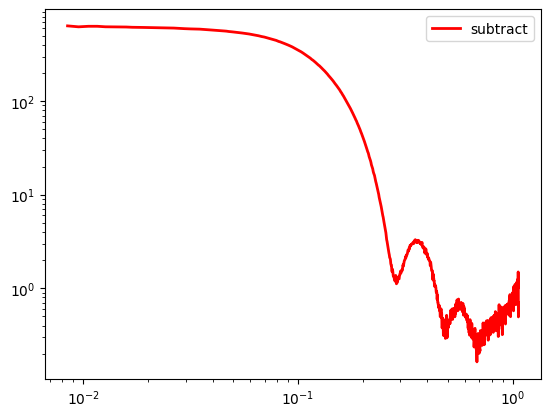

In [20]:
substract = 'path/*3.txt'
processor.load_txt(substract)
fig,ax =plt.subplots()
q_sub, i_sub = processor.get_data(substract)
ax.loglog(q_sub ,i_sub,label = 'subtract',linewidth=2,color = 'red')
ax.legend();

- With all plots

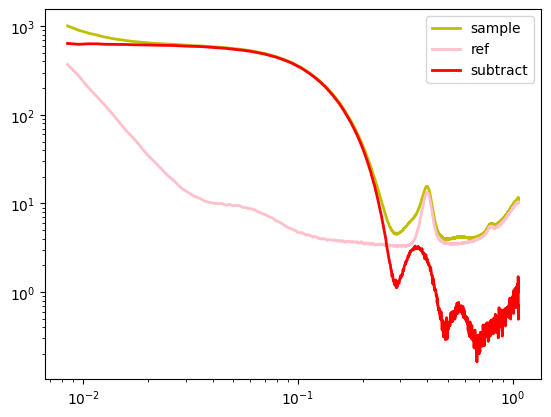

In [21]:
fig,ax = plt.subplots()
ax.loglog(q_sample, i_sample,label = 'sample',linewidth=2,color ='y')
ax.loglog(q_ref, i_ref,label = 'ref',linewidth=2,color = 'pink')
ax.loglog(q_sub ,i_sub,label = 'subtract',linewidth=2,color = 'red')
ax.legend();

### Notes:
- Dependencies:
Ensure you have installed the required libraries: h5py, numpy, fabio, pyFAI, matplotlib, opencv-python, and IPython (if using Jupyter).
- File Formats:
The code expects HDF5 files with a specific structure (as generated by the beamline) and a mask file readable by fabio
- Integration Options:
    Use integrate_mean=True to integrate the mean image of all frames.
    Use normalize=True to have the integrated intensity normalized using the diode current value (averagemi8b) and exposure time.
- Output:
    - Integration results are saved as text files in the "integration" folder.
    - Plots are saved as PNG images in the "plots" folder.
    - A video is generated from the plots.
- Customization:
You can adjust the sectors (angle and delta_angle) as needed for your experiment. The default sectors are defined as a list of tuples [(angle, delta angle)]that will integrate on angle range from angle-delta angle to angle+delta angle  (e.g., sectors =[(30, 5), (60, 10)]= the defaul value is [(0, 180)]).
